## Local Import

* working localy trim the data to ensure you can work with it locally <br/>
*(local computer doesn't have sufficient memory to join all tables so trim down appropriate attributes)*

In [15]:
# If import's not installed pip install all

# import sys
# try: 
#    for plotly
#    !{sys.executable} -m pip install plotly --upgrade
#    !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.2"

#    to plot the geo data 
#    !{sys.executable} -m pip install geopandas==0.3.0
#    !{sys.executable} -m pip install pyshp==1.2.10
#    !{sys.executable} -m pip install shapely==1.6.3
#    !{sys.executable} -m pip install chart_studio
#    !{sys.executable} -m pip install plotly-geo
#    !{sys.executable} -m pip install folium

#    to plot the decistion tree
# had to use conda install for: 
#    conda install python-graphviz
#    !{sys.executable} -m pip install pydotplus
# except ImportError: 
#    print("already installed")

# I also added npextentions found (https://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md)
# used conda install so it all came prepacaged then I enabled the extention 

In [17]:
# imports | path info | json to pandas dataframe util funciton 
import json, csv, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import seaborn as sns 

# for log function
import math

# clustering / unsupervised learning import
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Decision Tree Libraries
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

# Decision Tree Print out
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# plotly imports 
import plotly
from plotly import __version__
print('running plotly = {}'.format(__version__))
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

# path info
root_path = "/Users/2015mbp16gb256gb/Documents/school/Fall_2019/4502-Data_Mining/Group_Project/Group1/yelp_dataset/"
rbu_path = root_path + "rbu_merge.json"
filtered_merge_path = root_path + "filtered_merge.json"

# converstion util function
def JSON_to_dataFrame(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() ] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df

# for plotly ofline 
init_notebook_mode(connected=True)

running plotly = 4.2.1


### Reviewing The Buiness Data

In [18]:
%%time

business_df = JSON_to_dataFrame(root_path + "business.json")
business_df['text'] = business_df['state'] + ', ' + business_df['city']

CPU times: user 6.43 s, sys: 2.67 s, total: 9.1 s
Wall time: 9.68 s


In [19]:
# display states/province in business file
business_df.groupby('state').state.count()

state
AB      8012
AK         2
AL         3
AR         1
AZ     56686
BAS        1
BC         1
CA        19
CON        1
CT         3
DOW        1
DUR        1
FL         4
GA         2
IL      1932
NC     14720
NE         2
NJ         1
NM         1
NV     36312
NY        22
OH     14697
ON     33412
PA     11216
QC      9219
SC      1162
TN         1
TX         6
UT         1
VA         2
VT         2
WA         3
WI      5154
XGL        1
XGM        4
XWY        2
Name: state, dtype: int64

* 11 main states found

### Kmeans

* Kmeans can be sensative to outliers but most of the information is naturally clumped so we dont have to worry 

In [20]:
# find all kmeans and groups
def find_df_groups_plus_kmeans(df, lat, lon, n_clusters): 
    # transform the data 
    coordinates_df = df[[lat, lon]].copy()

    pca = PCA(n_components=2)
    coordinates = pca.fit_transform(coordinates_df)
    
    #Train model
    kmeans = KMeans(n_clusters=n_clusters).fit(coordinates)
    
    # assign lables
    df['labels'] = pd.DataFrame(kmeans.labels_)
    
    return (df, kmeans)

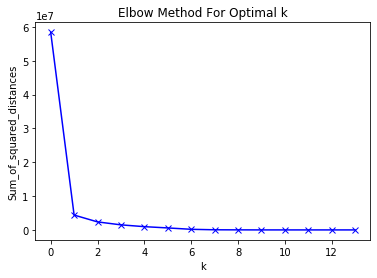

In [21]:
# plot elbo method
Sum_of_squared_distances = []
K = 15

for k in range(1, K):
    business_df, km = find_df_groups_plus_kmeans(business_df, 'latitude', 'longitude', k)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
# group using k=10
n_clusters = 10
business_df, km = find_df_groups_plus_kmeans(business_df, 'latitude', 'longitude', n_clusters)

In [23]:
# let's plot cluster information for nationwide visualization"""
"""
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = business_df['longitude'],
        lat = business_df['latitude'],
        text = business_df['text'],
        mode = 'markers',
        marker_color = business_df['labels'],
        ))

fig.update_layout(
        title = 'US Cluster<br>(hover for spicific informaiton)',
        geo_scope='usa',
    )
fig.show()
"""

"\nimport plotly.graph_objects as go\n\nfig = go.Figure(data=go.Scattergeo(\n        lon = business_df['longitude'],\n        lat = business_df['latitude'],\n        text = business_df['text'],\n        mode = 'markers',\n        marker_color = business_df['labels'],\n        ))\n\nfig.update_layout(\n        title = 'US Cluster<br>(hover for spicific informaiton)',\n        geo_scope='usa',\n    )\nfig.show()\n"

![img](map.png)

#### Deeper look at clustered business data

In [24]:
# look at the difference between the review count and stars
national_review_mean = business_df["review_count"].mean()
national_stars_mean = business_df["stars"].mean()
print("national_stars_mean = ", national_stars_mean)
print("national_review_mean = ", national_review_mean)

national_stars_mean =  3.585626839867296
national_review_mean =  33.53896235378409


In [25]:
# means of the clustered info
def sortSecond(val): 
    return val[1] 

review_count = []
rating_stars = []
ratio_open_close = []
count = []
for n in range(n_clusters):
    indexes = business_df[business_df["labels"] != n].index
    temp = business_df.copy()
    temp.drop(indexes, inplace=True)
    rating_stars.append((n, temp["stars"].mean()))
    review_count.append((n, temp["review_count"].mean()))
    count.append((n, temp.count()))
    ratio_open_close.append((n, 1 - temp["is_open"].sum() / temp["is_open"].count() ))

print("Star's mean per cluster = ")
rating_stars.sort(key = sortSecond, reverse = True)
for i, value in rating_stars: 
    print(i, value)
    
review_count.sort(key = sortSecond, reverse = True)
print("\nReview_count's mean per cluster = ")
for i, value in review_count: 
    print(i, value) 
    
ratio_open_close.sort(key = sortSecond, reverse = True)    
print("\nRatio of closed businesses per cluster = ")
for i, value in ratio_open_close: 
    print(i, "=", value) 
    
print("\nCount per cluster = ")
for i, value in count: 
    print("--"+str(i)+"--",value)

Star's mean per cluster = 
4 3.7071783749471012
1 3.696218730219886
7 3.634898312418866
6 3.610895696006204
8 3.577598502406846
3 3.539541619443395
5 3.505374880936182
9 3.4647850854479545
2 3.3856143856143857
0 3.3563926872325784

Review_count's mean per cluster = 
1 61.79425929493354
4 35.327955282832555
3 26.116861856189395
6 25.130283055447848
8 25.06141914779818
0 22.77672720744442
9 21.219057483169344
5 21.129133215403456
7 19.03147987884033
2 12.08066933066933

Ratio of closed businesses per cluster = 
0 = 0.20606804105203314
9 = 0.20041429311237702
1 = 0.1858436304593114
6 = 0.18301667312911984
7 = 0.17265253137170056
4 = 0.17241500916913532
2 = 0.16458541458541454
8 = 0.15920841504724548
3 = 0.15627754690844986
5 = 0.14648251462784057

Count per cluster = 
--0-- business_id     33421
name            33421
address         33421
city            33421
state           33421
postal_code     33421
latitude        33421
longitude       33421
stars           33421
review_count    3342

*********
### Merging Files and filter out anything not in the NV cluster
* merge review, business, and user. Clean format to ensure no merge conflicts

In [26]:
%%time

review_df = JSON_to_dataFrame(root_path + "review.json")
business_df = JSON_to_dataFrame(root_path + "business.json")
user_df = JSON_to_dataFrame(root_path + "user.json")
# tip_df = JSON_to_dataFrame(root_path + "tip.json")                     /not used
# checkin_df = JSON_to_dataFrame(root_path + "checkin.json")             /not used

CPU times: user 3min 33s, sys: 3min 49s, total: 7min 23s
Wall time: 9min 5s


In [27]:
# utility function to make a dict of columns with table name added
# used for the renaming of column names
def make_columns(lst, base):
    ret = {}
    for i in lst:
        ret[i] = base + '_' + i
    return ret

In [28]:
# return dataframe with column names updated to "table + _column_name"
def process_df(a_df, table): 

    col_list = [i for i in a_df]
    new_dict = make_columns(col_list, table)
    return a_df.rename(columns=new_dict)

In [29]:
# group the cluster and evaluate lables
def filter_Kcluster(df, st):
    n_clusters = 10
    business_df, km = find_df_groups_plus_kmeans(df, 'latitude', 'longitude', n_clusters)
    
    groupby_lables = business_df.groupby('labels').agg(lambda x:x.value_counts().index[0])
    state_lables = list(groupby_lables['state'])
    
    # find the index number for our group
    for idx, val in enumerate(state_lables): 
        if val == st: 
            return df[df['labels'] == idx].copy()
    return None

In [30]:
%%time
#                 0             1      2        3         4           5       6        7         8
review_col = ['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id']

# ***Update review_df*** 
review_drop = [review_col[1], review_col[3]]
review_df = review_df.drop(review_drop, axis=1)
review_df = process_df(review_df, 'review')

CPU times: user 15.1 s, sys: 39.1 s, total: 54.2 s
Wall time: 1min 9s


In [31]:
%%time
#                  0             1           2             3         4      5       6           7          8         9       10              11           12     13
business_col = ['address','attributes','business_id','categories','city','hours','is_open', 'latitude','longitude','name','postal_code','review_count','stars','state']                              

# ***Update business_df***
business_drop = [business_col[0], business_col[5]]
business_df = business_df.drop(business_drop, axis=1)

Group_NV_df = filter_Kcluster(business_df, 'NV')

business_df = process_df(Group_NV_df, 'business')

CPU times: user 1min 25s, sys: 6.57 s, total: 1min 31s
Wall time: 1min 31s


In [32]:
%%time

rb_merge = pd.merge(review_df, business_df, left_on='review_business_id', right_on='business_business_id', how='inner')

CPU times: user 12.1 s, sys: 623 ms, total: 12.7 s
Wall time: 12.1 s


In [33]:
%%time

#                  0             1                     2                 3                 4                5                   6              7                     8                   9                10                   11             12     13      14       15      16      17      18             19       20          21
user_col = ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list', 'compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer', 'cool','elite','fans','friends','funny','name','review_count','useful','user_id','yelping_since']   

# ***Update _user_df***
user_drop = [user_col[7], user_col[8], user_col[9], user_col[10], user_col[11]]
user_df = user_df.drop(user_drop, axis=1)

user_df = process_df(user_df, 'user')

CPU times: user 5.75 s, sys: 19.2 s, total: 24.9 s
Wall time: 33.4 s


In [34]:
%%time

rbu_merge = pd.merge(rb_merge, user_df, left_on='review_user_id', right_on='user_user_id', how='inner')

CPU times: user 18.7 s, sys: 20.9 s, total: 39.6 s
Wall time: 47.2 s


In [35]:
%%time

rbu_drop = ['review_business_id','review_user_id']
rbu_merge = rbu_merge.drop(rbu_drop, axis=1)

CPU times: user 16.3 s, sys: 14.1 s, total: 30.3 s
Wall time: 31.7 s


*********
### Write Merged DataFrame Back To Json file for quicker processing

In [ ]:
# convert df to json format util funciton
def df_to_json(df, path):
    new_dict = {}
    num_col = len([i for i in df])

    with open(r'{}'.format(path), 'w') as writer: 

        for row in df.itertuples():
            
            for idx, col in enumerate(df): 
                if type(row[idx+1]) == int: 
                    new_dict[col] = int(row[idx+1])
                if type(row[idx+1]) == float: 
                    new_dict[col] = float(row[idx+1])
                else: 
                    new_dict[col] = str(row[idx+1])
                
            writer.write(json.dumps(new_dict) + '\n')
            new_dict = {}         



In [ ]:
%%time 

# df_to_json(rbu_merge, filtered_merge_path)

****
## (Start) Open "filtered_merge" file for further processing

In [ ]:
%%time

# merged_df = JSON_to_dataFrame(filtered_merge_path)

In [36]:
merged_df = rbu_merge

*It looks like the business star ratings are more of a normal distribution than the review stars. we will use this attribute compair to 5 star ratings for businesses.* 

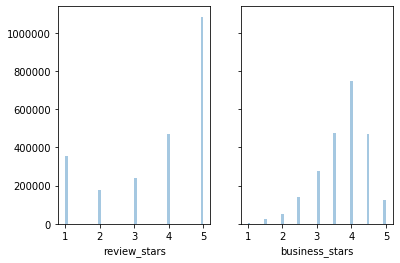

In [37]:
# call regplot on each axes
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.distplot(merged_df.review_stars, kde=False, ax=ax1)
sns.distplot(merged_df.business_stars, kde=False, ax=ax2)

#sns.set(rc={'figure.figsize':(10,5)})

In [39]:
# if business has rating of 5 star add 1 to list othrwise 0
# add this information as a new column
def update_list(val): 
    if val == 5: 
        return 1
    else: 
        return 0

## Decision Tree - find the attibute combination most likely for 5 star rating avg using information gain ratio

In [45]:
# if business has rating of 5 star add 1 to list othrwise 0
# add this information as a new column
def update_list(val): 
    if val == 5: 
        return 1
    else: 
        return 0
    
merged_df['star_target'] = [update_list(x) for x in merged_df['business_stars'] ]
business_df['star_target'] = [update_list(x) for x in business_df['business_stars'] ]


In [46]:
def decistion_tree_classifier(x, y, feature_col):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) 
    
    # Create dtc object
    calc = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    
    # Train dtc
    calc = calc.fit(X_train, y_train)
    
    #Show Prediction for the test dataset
    y_pred = calc.predict(X_test)

    # Show Accuracy
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    # print tree given our model
    dot_data = StringIO()
    export_graphviz(calc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_col, class_names=['False','True'])

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('decision_tree.png')
    return graph.create_png()
    

Accuracy: 0.9456603643597439


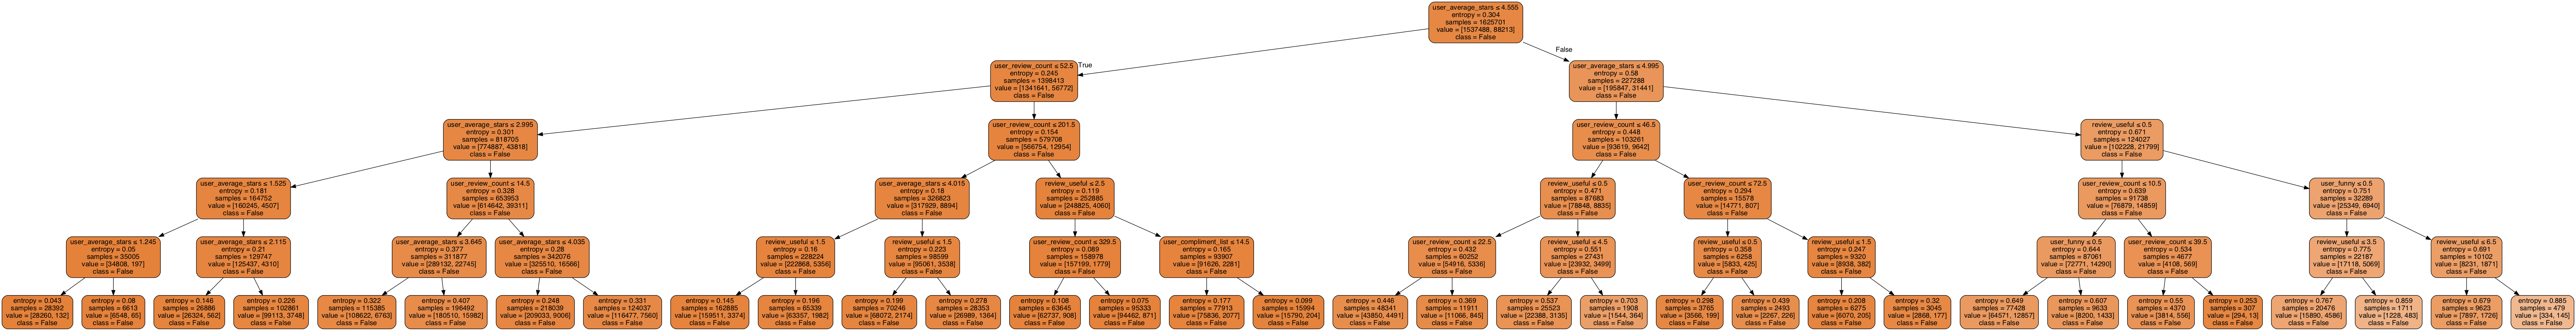

In [78]:
# make feature and key variables
# others to clean and add ['business_name', 'business_attributes', 'business_categories', 'user_name',]
feature_col = ['review_useful', 'user_review_count', 'user_useful', 'user_funny', 'user_cool', 'user_fans', 'user_average_stars', 'user_compliment_hot', 'user_compliment_more', 'user_compliment_cute', 'user_compliment_list', 'user_compliment_cool', 'user_compliment_funny']
x = merged_df[feature_col]
y = merged_df.star_target

all_img = decistion_tree_classifier(x, y, feature_col)
Image(all_img)

user_average_star < 4.55 --> user_average_stars < 4.995 --> review_usefull < .5 --> user_funny > .5 --> review_useful > 6.5
entropy = .885

The first split happens when the reviewers have an average ratering of over 4.555. This is intuitive since it make sense that you have a grater chance of reciving a 5 star on your business when the reviews are people that tend to leave hither star ratings. Of Those people the ones that average the highest of 4.995 we find the highest entropy by looking at the the ones in this category that have a usefull rating of over 6.5 and funny rating of over .5. This is interesting becasue it is showing us that we need to seek out light harded thoughfull reviewer clientell. 

In [48]:
# tokenize string

def tokenize(string): 
    token = string.split(',')
    temp = []
    for i in token: 
        temp.append(i.strip())
    
    return temp

In [52]:
# split each category into dic
def categories_dict(df): 
    categories_dic = []
    
    for idx in df.index:
        if df.business_categories[idx] is not None: 
            ret_array = tokenize(df.business_categories[idx])
            
        
        for num, i in enumerate(ret_array): 
            # compare against top attributes user_average_stars, review_usefull, user_funny
            business_name = i
            
            # categories_dic.append((business_id, business_name, user_average_star, user_useful, user_funny, business_stars))
            categories_dic.append((business_name, df.star_target[idx]))

                
            
    return categories_dic

In [53]:
# convert categories dict into dataframe
# col = ["business_id", "business_name", "user_average_star", "user_useful", "user_funny", "business_stars"]
col = ["name", "star_target"]

category_df = pd.DataFrame(categories_dict(business_df), columns=col)

category_df

,name,star_target
0,Hair Salons,0
1,Hair Stylists,0
2,Barbers,0
3,Men's Hair Salons,0
4,Cosmetics & Beauty Supply,0
...,...,...
153900,Water Heater Installation/Repair,1
153901,Home Services,1
153902,Plumbing,1
153903,Massage,0


In [149]:
# split each business name into dic
def names_dict(df):
    names_dic = []
    for idx in df.index:
        if df.business_name[idx] is not None: 
            name_array = tokenize(df.business_name[idx])

        for num, i in enumerate(name_array): 
            names_dic.append((i, df.business_latitude[idx], df.business_longitude, df.star_target[idx]))
            
    return names_dic


In [150]:
col = ["name", "latitude", "longiude", "star_target"]

# convert business name dict into dataframe
name_df = pd.DataFrame(names_dict(business_df), columns=col)

name_df

,name,latitude,longiude,star_target
0,Supercuts,36.099872,7 -115.074574 17 -115.128529 18 ...,0
1,Carluccio's Tivoli Gardens,36.100016,7 -115.074574 17 -115.128529 18 ...,0
2,Myron Hensel Photography,36.116549,7 -115.074574 17 -115.128529 18 ...,1
3,Fremont Arcade,36.169993,7 -115.074574 17 -115.128529 18 ...,0
4,Las Vegas Motorcars,36.225851,7 -115.074574 17 -115.128529 18 ...,0
...,...,...,...,...
37257,Premier Landscape Maintenance,36.168824,7 -115.074574 17 -115.128529 18 ...,0
37258,Las Vegas Kung Fu Academy,35.989577,7 -115.074574 17 -115.128529 18 ...,0
37259,Starbucks,36.041407,7 -115.074574 17 -115.128529 18 ...,0
37260,Sanderson Plumbing,36.213732,7 -115.074574 17 -115.128529 18 ...,1


In [58]:
def find_feature_target_col(df, target): 
    feat = []
    trg = target
    for i in df: 
        if i != trg:
            feat.append(i)
    return (trg, feat)

In [59]:
def decistion_tree_get_dummies(df): 
    
    # find feature and key variables
    star_col, feature_col = find_feature_target_col(df, 'star_target')
    x = df[feature_col]
    y = df[star_col]
    
    # code the names to ensure this works with categorical data
    x = pd.get_dummies(x)
    # get the features form the updated dummiess
    star_col, feature_col = find_feature_target_col(x, 'star_target')

    # split the data into test and train
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
    
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    
    # fit the model
    tree.fit(X_train, y_train)
    
    #Show Prediction for the test dataset
    y_pred = tree.predict(X_test)

    # Get Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # print tree given our model
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_col, class_names=['False','True'])

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('decision_tree.png')
    return (accuracy, graph.create_png())
    

In [183]:
# Print tree for category_df
accuracy, tree_img = decistion_tree_get_dummies(category_df)
# Image(tree_img)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.7968682318288139


![img](decision_tree_category.png)

In [13]:
# print tree for name_df
accuracy, tree_img = decistion_tree_get_dummies(name_df)
Image(tree_img)

In [12]:
print("Accuracy: {}".format(accuracy))

Accuracy: 0.8490305653048011


![img](decision_tree_name.png)

## Naive Bayes - Find the probability of a category attaining a 5 star rating

In [61]:
# if business has multiple entries calassify as chain with a 1 otherwise 0
unique_list = []

def check_unique(lst, entry): 
    for i in lst: 
        if i == entry: 
            return 1
        
    lst.append(entry)
    return 0

merged_df['is_chain'] = [check_unique(unique_list, x) for x in merged_df.business_name]


### Predict (X) geting a 5 star rating; where X is a given category
(first lets look at the probability of getting a five star vs not getting a five star)

In [159]:
# find the probability of yes and no
N = name_df['name'].count()

num_yes = name_df[name_df['star_target']==1].star_target.count()
num_no = N - num_yes

print("C_1 = yes (five star rating)")
print("C_2 = no  (five star rating)")
print("P(C_i|X) = P(X| C_i) P(C_i)")
print("P(C_i)")

stars_yes = num_yes / N
stars_no = num_no / N
print("P(five_star = \"yes\") = {}/{} = {}".format(num_yes, N, stars_yes)) 
print("P(five_star = \"no\") = {}/{} = {}".format(num_no, N, stars_no))


C_1 = yes (five star rating)
C_2 = no  (five star rating)
P(C_i|X) = P(X| C_i) P(C_i)
P(C_i)
P(five_star = "yes") = 7064/37262 = 0.1895765122645054
P(five_star = "no") = 30198/37262 = 0.8104234877354946


(now determin probabilities based on a given calss)

In [178]:
# function for calculating pobabilities
def prob_entry(df, yes_total, no_total): 
    five_star_yes = df[df['star_target']==1].star_target.count()
    five_star_no = df[df['star_target']==0].star_target.count()
    prob = (five_star_yes / yes_total, five_star_no / no_total)
    return prob

def calc_probabilities(df, column_for_prob, num_yes, num_no): 
    prob_five_star = []
    # group and find the probabilities based on group
    for name, group in df.groupby(column_for_prob): 
        prob_five_star.append((name, prob_entry(group, num_yes, num_no)))
        
    # split array into lists based on attibute
    list_of_column_for_prob = []
    list_of_prob_yes = []
    list_of_porb_no = []

    for name, (yes, no) in prob_five_star: 
        list_of_column_for_prob.append(name)
        list_of_prob_yes.append(yes)
        list_of_porb_no.append(no)
        
    # combine lists and add to dataframe    
    zippedList =  list(zip(list_of_column_for_prob, list_of_prob_yes, list_of_porb_no))
    
    ret = pd.DataFrame(zippedList, columns = [column_for_prob, 'yes_prob', 'no_prob'])
    ret['lat'] = name_df.latitude
    ret['lon'] = name_df.longiude
    return ret

def add_prob_five_star_yes(df, stars_yes, stars_no):
    df['P(category|star=yes)*P(star=yes)'] = df['yes_prob'] * stars_yes
    df['P(category|star=no)*P(star=no)'] = df['no_prob'] * stars_no
    return df

In [161]:
# split up the categories into individual probabilities

def tokenize(string): 
    token = string.split(',')
    temp = []
    for i in token: 
        temp.append(i.strip())
    
    return temp
 


def take_dict(df): 
    categories_dic = {}
    
    for idx in df.index:  
        ret_array = tokenize(str(df["business_categories"][idx]))
        for i in ret_array: 
            if i not in categories_dic.keys():
                categories_dic[i] = (0, 0)
            else:
                if merged_df.star_target[idx] == 1: 
                    (num_count_five, total_review_count) = categories_dic[i]
                    num_count_five += 1
                    total_review_count += 1
                    categories_dic[i] = (num_count_five, total_review_count)
                else: 
                    (num_count_five, total_review_count) = categories_dic[i]
                    total_review_count += 1
                    categories_dic[i] = (num_count_five, total_review_count)
            
    return categories_dic

test = take_dict(name_df)

KeyError: 'business_categories'

##### P(Category| C_i) 

In [179]:
prob_categories_df = calc_probabilities(name_df, 'name', num_yes, num_no)

##### P(Category| C_i) P(C_i)

In [180]:
prob_categories_df = add_prob_five_star_yes(prob_categories_df, stars_yes, stars_no)

#### Prediction

In [181]:
prob_categories_df.sort_values(by="yes_prob", ascending=False)

,name,yes_prob,no_prob,lat,lon,P(category|star=yes)*P(star=yes),P(category|star=no)*P(star=no)
6784,DDS,0.006512,0.001954,36.142201,7 -115.074574 17 -115.128529 18 ...,0.001235,0.001583
15825,MD,0.002973,0.008212,36.115029,7 -115.074574 17 -115.128529 18 ...,0.000564,0.006656
6768,DC,0.002123,0.000265,36.271766,7 -115.074574 17 -115.128529 18 ...,0.000403,0.000215
18411,OD,0.001557,0.000729,36.101063,7 -115.074574 17 -115.128529 18 ...,0.000295,0.000590
6822,DMD,0.001416,0.000530,36.131892,7 -115.074574 17 -115.128529 18 ...,0.000268,0.000429
...,...,...,...,...,...,...,...
10944,Guardian Heating & Cooling,0.000000,0.000033,36.127195,7 -115.074574 17 -115.128529 18 ...,0.000000,0.000027
10942,Guardian Angel Cathedral,0.000000,0.000033,36.165625,7 -115.074574 17 -115.128529 18 ...,0.000000,0.000027
10941,Guaranteed Pool Service,0.000000,0.000033,36.276992,7 -115.074574 17 -115.128529 18 ...,0.000000,0.000027
10939,Guaranteed Carpet Care LLC,0.000000,0.000033,36.200097,7 -115.074574 17 -115.128529 18 ...,0.000000,0.000027


In [182]:
top_hundred_name = prob_categories_df.sort_values(by="P(category|star=yes)*P(star=yes)", ascending=False)[:100].copy()
top_hundred_name

,name,yes_prob,no_prob,lat,lon,P(category|star=yes)*P(star=yes),P(category|star=no)*P(star=no)
6784,DDS,0.006512,0.001954,36.142201,7 -115.074574 17 -115.128529 18 ...,0.001235,0.001583
15825,MD,0.002973,0.008212,36.115029,7 -115.074574 17 -115.128529 18 ...,0.000564,0.006656
6768,DC,0.002123,0.000265,36.271766,7 -115.074574 17 -115.128529 18 ...,0.000403,0.000215
18411,OD,0.001557,0.000729,36.101063,7 -115.074574 17 -115.128529 18 ...,0.000295,0.000590
6822,DMD,0.001416,0.000530,36.131892,7 -115.074574 17 -115.128529 18 ...,0.000268,0.000429
...,...,...,...,...,...,...,...
19906,Pole Fitness Studio,0.000283,0.000000,36.142864,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000000
23135,Skincare By Mi,0.000283,0.000000,36.126056,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000000
8748,Esq,0.000283,0.000066,36.025707,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000054
13638,Khina Eyebrow Threading & Henna Art,0.000283,0.000000,36.091767,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000000


#### Coverage and Accuracy

In [175]:
# find the coverage and accuracy
def coverage_accuracy(df, yes_total): 
    five_star_yes = df[df['star_target']==1].star_target.count()
    count = df.star_target.count()
    coverage = (five_star_yes / yes_total)
    accuracy = five_star_yes / count
    return (coverage, accuracy)

def find_coverage_accuracy(df):
    columns = 'name'
    probs = []

    for name, group in df.groupby(columns): 
        coverage, accuracy = coverage_accuracy(group, num_yes)
        probs.append((name, coverage, accuracy))
    
    
    
    return probs

In [143]:
category_probs = find_coverage_accuracy(category)
category_result = pd.DataFrame(category_probs)
category_result.sort_values(by=1, ascending=False)

,0,1,2
526,Home Services,0.043564,0.281469
110,Beauty & Spas,0.039540,0.307731
968,Shopping,0.034590,0.175073
495,Health & Medical,0.033088,0.250665
640,Local Services,0.027978,0.274436
...,...,...,...
600,Kitchen Supplies,0.000000,0.000000
599,Kitchen Incubators,0.000000,0.000000
590,Junkyards,0.000000,0.000000
583,Japanese Curry,0.000000,0.000000


In [140]:
name_probs = find_coverage_accuracy(name_df)
name_result = pd.DataFrame(name_probs)
name_result.sort_values(by=1, ascending=False)

,0,1,2
6784,DDS,0.001469,0.438095
15825,MD,0.000671,0.078067
6768,DC,0.000479,0.652174
18411,OD,0.000351,0.333333
6822,DMD,0.000319,0.384615
...,...,...,...
10944,Guardian Heating & Cooling,0.000000,0.000000
10942,Guardian Angel Cathedral,0.000000,0.000000
10941,Guaranteed Pool Service,0.000000,0.000000
10939,Guaranteed Carpet Care LLC,0.000000,0.000000


### Visualize clustered K-mans NV informaiton

once the we have a resonable amount of business lets visualize

In [113]:
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
import geopandas
from sqlalchemy import create_engine
import sqlalchemy.sql
from shapely.geometry import Point, Polygon

In [176]:
# look at all the businesses with average star rating of 5
test_df =  top_hundred_name
test_df

,name,yes_prob,no_prob,lat,lon,P(category|star=yes)*P(star=yes),P(category|star=no)*P(star=no)
6784,DDS,0.006512,0.001954,36.142201,7 -115.074574 17 -115.128529 18 ...,0.001235,0.001583
15825,MD,0.002973,0.008212,36.115029,7 -115.074574 17 -115.128529 18 ...,0.000564,0.006656
6768,DC,0.002123,0.000265,36.271766,7 -115.074574 17 -115.128529 18 ...,0.000403,0.000215
18411,OD,0.001557,0.000729,36.101063,7 -115.074574 17 -115.128529 18 ...,0.000295,0.000590
6822,DMD,0.001416,0.000530,36.131892,7 -115.074574 17 -115.128529 18 ...,0.000268,0.000429
...,...,...,...,...,...,...,...
19906,Pole Fitness Studio,0.000283,0.000000,36.142864,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000000
23135,Skincare By Mi,0.000283,0.000000,36.126056,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000000
8748,Esq,0.000283,0.000066,36.025707,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000054
13638,Khina Eyebrow Threading & Henna Art,0.000283,0.000000,36.091767,7 -115.074574 17 -115.128529 18 ...,0.000054,0.000000


In [177]:
# visualize location points using folium
import folium
 
NV = (36.188820, -115.207720)
 
# for speed purposes


colors = ['#000000', '#cc0099', '#3186cc']

  
# create empty map zoomed in on San Francisco
m = folium.Map(location=NV, zoom_start=10)


# add a marker for every record in the filtered data, use a clustered view
for lat, lon in zip(test_df['lat'], test_df['lon']):    
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        fill=True,
        ).add_to(m) 

display(m)


ValueError: Location should consist of two numerical values, but 7        -115.074574
17       -115.128529
18       -115.088115
20       -115.140685
21       -115.132800
             ...    
192586   -115.218557
192597   -115.101495
192598   -115.171698
192604   -115.177059
192608   -115.171920
Name: business_longitude, Length: 36337, dtype: float64 of type <class 'pandas.core.series.Series'> is not convertible to float.

********

## Unit Test

In [ ]:
# function to chop file down to in size to test
def JSON_to_dataFrame_2(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() [-500000:]] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df

# turn part of busines.json file into trunkated file for testing called (test.json)
test_path = root_path + 'test.json' 
parse_DataFrame1(JSON_to_dataFrame_2('business.json'), test_path)

In [ ]:
%%time

# take a small percentage of entries and convert to dataframe 
test_in_path = root_path + 'test.json' 
test_df = JSON_to_dataFrame(test_in_path)

# write that dataframe to file
test_out_path = root_path + 'test_out.json' 
parse_DataFrame1(test_df, test_out_path)

# convert that file back to dataframe (should be the same)
test2_df = JSON_to_dataFrame(test_out_path)

In [ ]:
# util function to compare dataframes
def test_DataFrame_to_Json(a_df_1, a_df_2): 
    
    df_list_1 = []
    df_list_2 = []
    catch_list = []
    
    for row in a_df_1.itertuples():
            
            for idx, col in enumerate(a_df_1):
                df_list_1.append((type(row[idx]), col))
                
    for row_2 in a_df_2.itertuples():
            
            for idx_2, col_2 in enumerate(a_df_2):
                df_list_2.append((type(row[idx_2]), col_2))
                
    for x,y in zip(df_list_1, df_list_2): 
        if x != y: 
            catch_list.append((x, y))
            
    for i in catch_list: 
        print(i)             # dataFrams have different types

In [ ]:
# function to view parts of a file that recieved an error message

def check_input_output(a_test_in_path, a_test_out_path, a_log_path):
    line_count = 0
    char_count = 0
    save1 = ""
    save2 = []
    cnt1 = 0
    cnt2 = 0
    
    with open(a_test_in_path, 'r') as read1, open(a_test_out_path, 'r') as read2: 
        for x, y in zip(read1, read2):
            x = x.strip()
            y = y.strip()
            
            in_line = x.split()
            out_line = y.split()
            for word1, word2 in zip(in_line, out_line):
                
                save2.append(word1)
                
                if cnt1 > 5:
                    save2.pop(0)
                cnt1 = cnt1 + 1

            
                word_list = list(word2)
                
                for char in word_list: 
                    save1 = save1 + char
                    if cnt2 > 70: 
                        save1 = save1[1:]
                    
                    if char_count == 139: 
                        print(save1)
                        print(" ".join(save2))
                        
                    char_count = char_count + 1
                    cnt2 += 1
                
            line_count = line_count + 1
            
check_input_output(test_in_path, test_out_path, log_path)